#**Image Classification using Vision Transformer**

###**Load Dataset**

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch import nn
import math
import os

In [2]:
!gdown 1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc

Downloading...
From (original): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc
From (redirected): https://drive.google.com/uc?id=1vSevps_hV5zhVf6aWuN8X7dd-qSAIgcc&confirm=t&uuid=cce5d267-d578-45ac-832f-8268fadfd434
To: /content/flower_photos.zip
100% 230M/230M [00:02<00:00, 93.8MB/s]


In [3]:
!unzip ./flower_photos.zip

Archive:  ./flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flower_photos/daisy/10172379554_b296050f82_n.jpg  
  inflating: flower_photos/daisy/10172567486_2748826a8b.jpg  
  inflating: flower_photos/daisy/10172636503_21bededa75_n.jpg  
  inflating: flower_photos/daisy/102841525_bd6628ae3c.jpg  
  inflating: flower_photos/daisy/1031799732_e7f4008c03.jpg  
  inflating: flower_photos/daisy/10391248763_1d16681106_n.jpg  
  inflating: flower_photos/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flower_photos/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flower_photos/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flower_photos/daisy/10466290366_cc72e33532.jpg  
  inflating: flower_photos/daisy/10466558316_a7198b87e2.jpg  
  inflating: flower_photos/daisy/10555749515_13a12a026e.jpg  
  inflating: flower_photos/daisy/

In [4]:
data_patch = "./flower_photos"

In [5]:
dataset = ImageFolder(root=data_patch)

In [6]:
num_samples = len(dataset)
classes = dataset.classes
num_classes = len(dataset.classes)

In [7]:
TRAIN_RATIO, VALID_RATIO = 0.8, 0.1

n_train_examples = int(num_samples * TRAIN_RATIO)
n_valid_examples = int(num_samples * VALID_RATIO)
n_test_examples = num_samples - n_train_examples - n_valid_examples

In [8]:
train_dataset, valid_dataset, test_dataset = random_split(
    dataset,
    [n_train_examples, n_valid_examples, n_test_examples]
)

###**Preprocessing**

In [9]:
# resize + convert to tensor
IMG_SIZE = 224

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [10]:
train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

###**Dataloader**

In [11]:
BATCH_SIZE = 512

train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

val_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE
)

###**Modeling**

In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, ff_dim, bias=True),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim, bias=True)
        )
        self.layernorm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, query, key, value):
        attn_output, _ = self.attn(query, key, value)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(query + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

In [13]:
class PatchPositionEmbedding(nn.Module):
    def __init__(self, img_size=224, embed_dim=512, patch_size=16, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        scale = embed_dim ** -0.5
        self.pos_embedding = nn.Parameter(scale * torch.randn(1, (img_size // patch_size) ** 2, embed_dim))
        self.device = device

    def forward(self, x):
        x = self.conv1(x) # (*, w, grid, grid)
        x = x.reshape(x.shape[0], x.shape[1], -1) # (*, w, grid*grid)
        x = x.permute(0, 2, 1) # (*, grid*grid, w)
        x += self.pos_embedding.to(self.device)
        return x

In [14]:
class VisionTransformerCls(nn.Module):
    def __init__(self, image_size, embed_dim, num_heads, ff_dim, dropout=0.1, device='cpu', num_classes=10, patch_size=16):
        super().__init__()
        self.patch_embedding = PatchPositionEmbedding(image_size, embed_dim, patch_size, device)
        self.transformer_encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, dropout)
        self.fc1 = nn.Linear(embed_dim, 20)
        self.fc2 = nn.Linear(20, num_classes)
        self.dropout = nn.Dropout(dropout)
        # self.relu = nn.ReLU()

    def forward(self, x):
        out = self.patch_embedding(x)
        out = self.transformer_encoder(out, out, out)
        out = out[:, 0, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [15]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)

In [18]:
model.to(device)

VisionTransformerCls(
  (patch_embedding): PatchPositionEmbedding(
    (conv1): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16), bias=False)
  )
  (transformer_encoder): TransformerEncoder(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (ffn): Sequential(
      (0): Linear(in_features=512, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=512, bias=True)
    )
    (layernorm1): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (layernorm2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (fc1): Linear(in_features=512, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=5, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [19]:
input, label = next(iter(train_loader))

In [20]:
input = input.to(device)

In [21]:
label

tensor([2, 0, 2, 0, 1, 2, 0, 3, 2, 4, 4, 1, 3, 3, 3, 1, 1, 2, 1, 0, 0, 3, 2, 3,
        2, 0, 2, 2, 1, 0, 1, 4, 3, 1, 4, 2, 4, 4, 1, 1, 3, 0, 3, 3, 3, 2, 2, 4,
        0, 3, 0, 3, 3, 3, 3, 4, 3, 1, 4, 4, 3, 4, 2, 2, 4, 1, 2, 3, 2, 1, 2, 3,
        1, 4, 3, 2, 1, 2, 1, 0, 0, 3, 0, 1, 4, 0, 2, 3, 2, 0, 3, 0, 1, 0, 0, 1,
        2, 4, 1, 0, 2, 4, 1, 4, 4, 4, 4, 1, 1, 4, 1, 2, 1, 1, 1, 0, 1, 0, 4, 4,
        1, 4, 0, 3, 0, 0, 3, 1, 4, 1, 4, 3, 1, 2, 3, 3, 2, 3, 0, 3, 1, 2, 1, 4,
        1, 2, 3, 2, 2, 0, 0, 0, 4, 3, 1, 1, 2, 4, 4, 3, 2, 1, 1, 3, 3, 1, 1, 2,
        3, 4, 3, 3, 2, 1, 3, 3, 1, 2, 2, 2, 4, 4, 4, 4, 4, 1, 4, 4, 2, 4, 1, 1,
        3, 2, 2, 1, 4, 3, 3, 4, 1, 4, 2, 2, 0, 0, 1, 4, 2, 4, 1, 3, 3, 3, 0, 0,
        2, 0, 1, 0, 4, 2, 2, 0, 0, 4, 2, 2, 3, 3, 1, 3, 3, 3, 4, 0, 2, 4, 1, 1,
        0, 4, 4, 1, 3, 2, 0, 1, 4, 2, 4, 1, 3, 2, 2, 3, 3, 2, 4, 4, 2, 4, 4, 1,
        0, 0, 0, 3, 4, 3, 3, 1, 0, 2, 3, 3, 3, 4, 4, 1, 1, 4, 0, 4, 3, 4, 1, 3,
        2, 1, 4, 0, 3, 0, 0, 2, 1, 3, 3,

In [22]:
predictions = model(input)

In [23]:
predictions

tensor([[-0.0037,  0.1529,  0.0638, -0.2004,  0.0697],
        [ 0.4262,  0.4815,  0.5706, -0.5633, -0.2580],
        [-0.4199,  0.2982,  0.3304,  0.5478, -0.4406],
        ...,
        [-0.3258,  0.1997, -0.2158, -0.0186,  0.6296],
        [-0.0024,  0.2722,  0.1959, -0.0659, -0.1256],
        [-0.5173,  0.0403, -0.4442,  0.2963,  0.7609]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

##**Trainer**

In [24]:
import time

def train_epoch(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [25]:
def evaluate_epoch(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [26]:
def train(model, model_name, save_model, optimizer, criterion, train_dataloader, valid_dataloader, num_epochs, device):
    train_accs, train_losses = [], []
    eval_accs, eval_losses = [], []
    best_loss_eval = 100
    times = []
    for epoch in range(1, num_epochs+1):
        epoch_start_time = time.time()
        # Training
        train_acc, train_loss = train_epoch(model, optimizer, criterion, train_dataloader, device, epoch)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        # Evaluation
        eval_acc, eval_loss = evaluate_epoch(model, criterion, valid_dataloader, device)
        eval_accs.append(eval_acc)
        eval_losses.append(eval_loss)

        # Save best model
        if eval_loss < best_loss_eval:
            torch.save(model.state_dict(), save_model + f'/{model_name}.pt')

        times.append(time.time() - epoch_start_time)
        # Print loss, acc end epoch
        print("-" * 59)
        print(
            "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
            "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, train_acc, train_loss, eval_acc, eval_loss
            )
        )
        print("-" * 59)

    # Load best model
    model.load_state_dict(torch.load(save_model + f'/{model_name}.pt', weights_only=True))
    model.eval()
    metrics = {
        'train_accuracy': train_accs,
        'train_loss': train_losses,
        'valid_accuracy': eval_accs,
        'valid_loss': eval_losses,
        'time': times
    }
    return model, metrics

## **Training**

In [27]:
image_size=224
embed_dim = 512
num_heads = 4
ff_dim = 128
dropout=0.1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformerCls(
    image_size=224, embed_dim=512, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout, num_classes=num_classes, device=device
)
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 100
save_model = './vit_flowers'
os.makedirs(save_model, exist_ok = True)
model_name = 'vit_flowers'

model, metrics = train(
    model, model_name, save_model, optimizer, criterion, train_loader, val_loader, num_epochs, device
)

-----------------------------------------------------------
| End of epoch   1 | Time: 18.85s | Train Accuracy    0.277 | Train Loss    1.774 | Valid Accuracy    0.311 | Valid Loss    1.544 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   2 | Time: 16.05s | Train Accuracy    0.335 | Train Loss    1.499 | Valid Accuracy    0.414 | Valid Loss    1.404 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   3 | Time: 16.57s | Train Accuracy    0.393 | Train Loss    1.385 | Valid Accuracy    0.409 | Valid Loss    1.329 
-----------------------------------------------------------
-----------------------------------------------------------
| End of epoch   4 | Time: 20.21s | Train Accuracy    0.417 | Train Loss    1.315 | Valid Accuracy    0.414 | Valid Loss    1.313 
--------------------------------------------------------

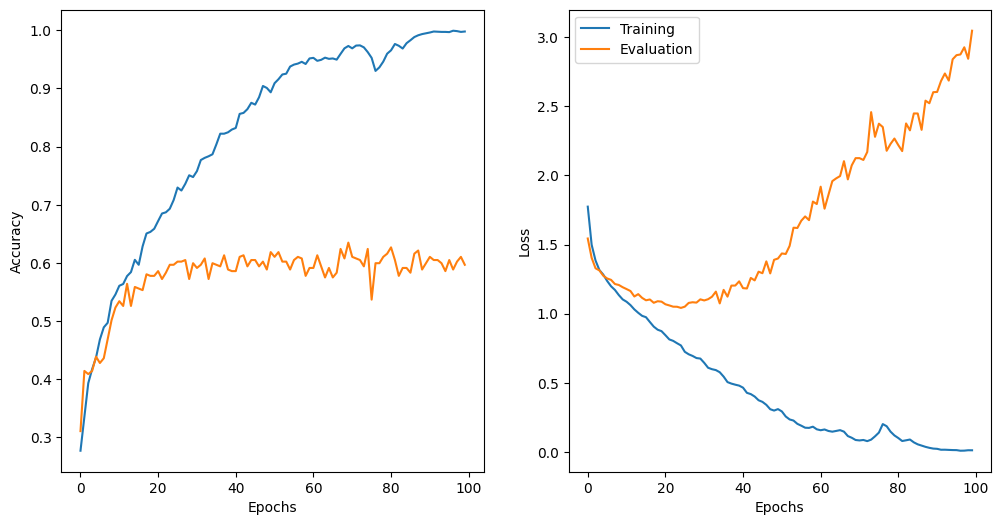

In [28]:
import matplotlib.pyplot as plt

def plot_result(num_epochs, train_accs, eval_accs, train_losses, eval_losses):
    epochs = list(range(num_epochs))
    fig, axs = plt.subplots(nrows = 1, ncols =2 , figsize = (12,6))
    axs[0].plot(epochs, train_accs, label = "Training")
    axs[0].plot(epochs, eval_accs, label = "Evaluation")
    axs[1].plot(epochs, train_losses, label = "Training")
    axs[1].plot(epochs, eval_losses, label = "Evaluation")
    axs[0].set_xlabel("Epochs")
    axs[1].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[1].set_ylabel("Loss")
    plt.legend()

plot_result(
    num_epochs,
    metrics["train_accuracy"],
    metrics["valid_accuracy"],
    metrics["train_loss"],
    metrics["valid_loss"]
)

In [29]:
test_acc, test_loss = evaluate_epoch(model, criterion, test_loader, device)
test_acc, test_loss

(0.6076294277929155, 2.8230972290039062)

#**Image Classification Vision Transformer Transfer Learning**

In [30]:
!pip install -q datasets accelerate evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


### **Modeling**

In [31]:
from transformers import ViTForImageClassification

id2label = {id:label for id, label in enumerate(classes)}
label2id = {label:id for id,label in id2label.items()}

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=5,
    id2label=id2label,
    label2id=label2id
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

### **Metric**

In [32]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

###**Trainer**

In [33]:
from transformers import ViTImageProcessor

feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [34]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"vit_flowers",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
import torch

def collate_fn(examples):
    # example => Tuple(image, label)
    pixel_values = torch.stack([example[0] for example in examples])
    labels = torch.tensor([example[1] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

<ipython-input-35-35eba9a719d0>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


###**Training**

In [36]:
import wandb
wandb.init(mode='disabled')

In [37]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.562165,0.950954
2,No log,0.264915,0.967302
3,No log,0.202075,0.964578
4,No log,0.182752,0.964578
5,No log,0.177882,0.959128
6,0.327900,0.170363,0.959128
7,0.327900,0.168096,0.956403
8,0.327900,0.167582,0.959128
9,0.327900,0.166488,0.959128
10,0.327900,0.164440,0.959128


TrainOutput(global_step=920, training_loss=0.20565067374187967, metrics={'train_runtime': 1184.5584, 'train_samples_per_second': 24.786, 'train_steps_per_second': 0.777, 'total_flos': 2.2752259898322125e+18, 'train_loss': 0.20565067374187967, 'epoch': 10.0})

In [38]:
outputs = trainer.predict(test_dataset)

In [39]:
outputs.metrics

{'test_loss': 0.27669113874435425,
 'test_accuracy': 0.9591280653950953,
 'test_runtime': 5.6273,
 'test_samples_per_second': 65.217,
 'test_steps_per_second': 2.132}